In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import os, sys

In [2]:
def count_null_or_zero(data, country):
    """
    Conta os registros nulos ou zero para os atributos New_cases, Cumulative_cases, 
    New_deaths, Cumulative_deaths em um país específico. Também inclui o total de 
    registros para o país.

    Args:
        data (pd.DataFrame): O dataframe com os dados COVID-19.
        country (str): O nome do país ou seu código.

    Returns:
        pd.Series: Contagem de valores nulos, zero e total de registros para o país.
    """
    # Filtrar os dados do país
    filtered_data = data[data['Country'] == country]
    
    # Contar nulos e zeros
    count_nulls = filtered_data[['New_cases', 'Cumulative_cases', 'New_deaths', 'Cumulative_deaths']].isnull().sum()
    count_zeros = (filtered_data[['New_cases', 'Cumulative_cases', 'New_deaths', 'Cumulative_deaths']] == 0).sum()
    
    # Somar nulos e zeros
    total_counts = count_nulls + count_zeros
    
    # Adicionar o total de registros do país
    total_counts['Total_records'] = len(filtered_data)
    
    return total_counts




In [3]:
def filter_datasets(data):
    """
    Filtra dois dataframes a partir do conjunto de dados original:
      1. Um dataframe contendo apenas registros cujo atributo 'New_cases' seja não-nulo e maior que zero.
      2. Um dataframe contendo apenas registros cujo atributo 'New_deaths' seja não-nulo e maior que zero.

    Args:
        data (pd.DataFrame): O dataframe original.

    Returns:
        tuple: Uma tupla contendo dois dataframes (df_cases, df_deaths).
    """
    # Filtra registros onde 'New_cases' não é nulo e maior que zero
    df_cases = data.dropna(subset=['New_cases'])
    df_cases = df_cases[df_cases['New_cases'] > 0]

    # Filtra registros onde 'New_deaths' não é nulo e maior que zero
    df_deaths = data.dropna(subset=['New_deaths'])
    df_deaths = df_deaths[df_deaths['New_deaths'] > 0]

    return df_cases, df_deaths


In [4]:
def list_countries_by_total_records(data):
    """
    Lista todos os países, seus códigos e respectivos números de registros,
    ordenados do maior para o menor.

    Args:
        data (pd.DataFrame): O dataframe com os dados COVID-19.

    Returns:
        pd.DataFrame: DataFrame com os países, códigos e o número total de registros ordenados.
    """
    # Contar registros por país e incluir código
    country_records = data.groupby(['Country', 'Country_code']).size().reset_index(name='Total_records')
    
    # Ordenar do maior para o menor
    country_records = country_records.sort_values(by='Total_records', ascending=False).reset_index(drop=True)
    
    return country_records


In [5]:
def plot_country_data(data, country):
    """
    Plota gráficos de New_cases, Cumulative_cases, New_deaths e Cumulative_deaths ao longo do tempo
    para um país específico.

    Args:
        data (pd.DataFrame): O dataframe filtrado.
        country (str): O nome do país ou código do país.

    Returns:
        None: Exibe os gráficos.
    """
    # Filtrar os dados para o país
    country_data = data[data['Country'] == country].copy()
    
    if country_data.empty:
        print(f"Nenhum dado encontrado para o país: {country}")
        return
    
    # Garantir que a coluna de data esteja no formato datetime
    country_data.loc[:, 'Date_reported'] = pd.to_datetime(country_data['Date_reported'])
    country_data = country_data.sort_values('Date_reported')
    
    # Lista de atributos para plotar
    attributes = ['New_cases', 'Cumulative_cases', 'New_deaths', 'Cumulative_deaths']
    
    # Loop para criar um gráfico para cada atributo
    for attribute in attributes:
        plt.figure(figsize=(20, 8))
        plt.plot(country_data['Date_reported'], country_data[attribute], marker='o', linestyle='-')
        plt.title(f"{attribute.replace('_', ' ')} in {country}")
        plt.xlabel("Date")
        plt.ylabel(attribute.replace('_', ' '))
        plt.grid(True)

In [6]:
def plot_countries_by_records(data, threshold, filter_above_threshold=False):
    """
    Plota um gráfico com a lista de países ordenados pelo número total de registros.
    Se `filter_above_threshold` for verdadeiro, exibe somente os países cuja quantidade
    de registros for maior que o threshold. Caso contrário, destaca países com valores
    abaixo ou iguais ao threshold.

    Args:
        data (pd.DataFrame): O dataframe com os países e o número total de registros.
        threshold (int): O limite para destacar ou filtrar países.
        filter_above_threshold (bool): Se verdadeiro, exibe somente países acima do threshold.

    Returns:
        None: Exibe o gráfico.
    """
    # Ordenar os dados pelo número total de registros
    data = data.sort_values(by='Total_records', ascending=False)
    
    if filter_above_threshold:
        # Filtrar somente países acima do threshold
        data = data[data['Total_records'] > threshold]
        title = f"Países com Total de Registros Acima de {threshold}"
        highlight_label = "Acima do Threshold"
    else:
        # Separar países acima e abaixo/igual ao threshold
        above_threshold = data[data['Total_records'] > threshold]
        below_or_equal_threshold = data[data['Total_records'] <= threshold]
        title = f"Países Ordenados por Total de Registros (Threshold: {threshold})"
        highlight_label = "Abaixo ou Igual ao Threshold"
    
    # Configurar o gráfico
    plt.figure(figsize=(12, 8))
    
    if filter_above_threshold:
        # Plotar apenas países acima do threshold
        plt.bar(data['Country'], data['Total_records'], label=highlight_label, alpha=0.7)
    else:
        # Plotar países acima do threshold
        plt.bar(above_threshold['Country'], above_threshold['Total_records'], label='Acima do Threshold', alpha=0.7)
        # Plotar países abaixo/igual ao threshold em destaque
        plt.bar(
            below_or_equal_threshold['Country'],
            below_or_equal_threshold['Total_records'],
            label=highlight_label,
            color='red',
            alpha=0.8
        )
    
    # Ajustar título, rótulos e legenda
    plt.title(title)
    plt.xlabel("Países")
    plt.ylabel("Total de Registros")
    plt.xticks(rotation=90, fontsize=8)
    plt.legend()
    plt.tight_layout()
    plt.show()




In [7]:
APP_PATH = os.getcwd()

file = "WHO-COVID-19-global-daily-data.csv"

dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("datasources", file))) 
# load the dataset
#dataset = dataset.sample(frac = 1) #embaralha os registros
dataset_original = dataset.copy()
dataset.head(5)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-04,TH,Thailand,SEAR,0.0,0,0.0,0
1,2020-01-04,RW,Rwanda,AFR,NaN,0,NaN,0
2,2020-01-04,TJ,Tajikistan,EUR,NaN,0,NaN,0
3,2020-01-04,TZ,United Republic of Tanzania,AFR,NaN,0,NaN,0
4,2020-01-04,AI,Anguilla,AMR,NaN,0,NaN,0


In [8]:
# Display the first few rows to understand the structure of the dataset
dataset.head(), dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427200 entries, 0 to 427199
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_reported      427200 non-null  object 
 1   Country_code       425420 non-null  object 
 2   Country            427200 non-null  object 
 3   WHO_region         427200 non-null  object 
 4   New_cases          207036 non-null  float64
 5   Cumulative_cases   427200 non-null  int64  
 6   New_deaths         207967 non-null  float64
 7   Cumulative_deaths  427200 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 26.1+ MB


(  Date_reported Country_code                      Country WHO_region  \
 0    2020-01-04           TH                     Thailand       SEAR   
 1    2020-01-04           RW                       Rwanda        AFR   
 2    2020-01-04           TJ                   Tajikistan        EUR   
 3    2020-01-04           TZ  United Republic of Tanzania        AFR   
 4    2020-01-04           AI                     Anguilla        AMR   
 
    New_cases  Cumulative_cases  New_deaths  Cumulative_deaths  
 0        0.0                 0         0.0                  0  
 1        NaN                 0         NaN                  0  
 2        NaN                 0         NaN                  0  
 3        NaN                 0         NaN                  0  
 4        NaN                 0         NaN                  0  ,
 None)

In [9]:
# Exemplo de uso: contar nulos ou zero para o país "Brazil"
country_name = "Brazil"
counts = count_null_or_zero(dataset, country_name)
counts

New_cases             692
Cumulative_cases       54
New_deaths            710
Cumulative_deaths      75
Total_records        1780
dtype: int64

In [10]:
# Aplicar a função para gerar o conjunto de dados filtrado, sem nulo e zerados para os atributos da análise - new_cases e new_deaths
df_cases, df_deaths = filter_datasets(data=dataset)

df_deaths.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98335 entries, 344 to 427011
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date_reported      98335 non-null  object 
 1   Country_code       97815 non-null  object 
 2   Country            98335 non-null  object 
 3   WHO_region         98335 non-null  object 
 4   New_cases          97411 non-null  float64
 5   Cumulative_cases   98335 non-null  int64  
 6   New_deaths         98335 non-null  float64
 7   Cumulative_deaths  98335 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.8+ MB


In [25]:
# Aplicar a função para listar países por número de registros
# Ordenar do maior para o menor
countries_by_records = list_countries_by_total_records(df_cases)
countries_by_records.head(60)

,Country,Country_code,Total_records
0,Bangladesh,BD,1695
1,India,IN,1583
2,China,CN,1443
3,Indonesia,ID,1428
4,United Kingdom of Great Britain and Northern I...,GB,1410
5,Belgium,BE,1392
6,Italy,IT,1390
7,Lithuania,LT,1389
8,Poland,PL,1387
9,Czechia,CZ,1386


In [21]:
# Aplicar a função para listar países por número de registros
# Ordenar do maior para o menor
countries_by_records = list_countries_by_total_records(df_deaths)
countries_by_records.head(30)

,Country,Country_code,Total_records
0,Italy,IT,1388
1,India,IN,1348
2,United Kingdom of Great Britain and Northern I...,GB,1329
3,Indonesia,ID,1275
4,Ireland,IE,1229
5,Russian Federation,RU,1222
6,Iran (Islamic Republic of),IR,1190
7,Belgium,BE,1184
8,Chile,CL,1173
9,Israel,IL,1170


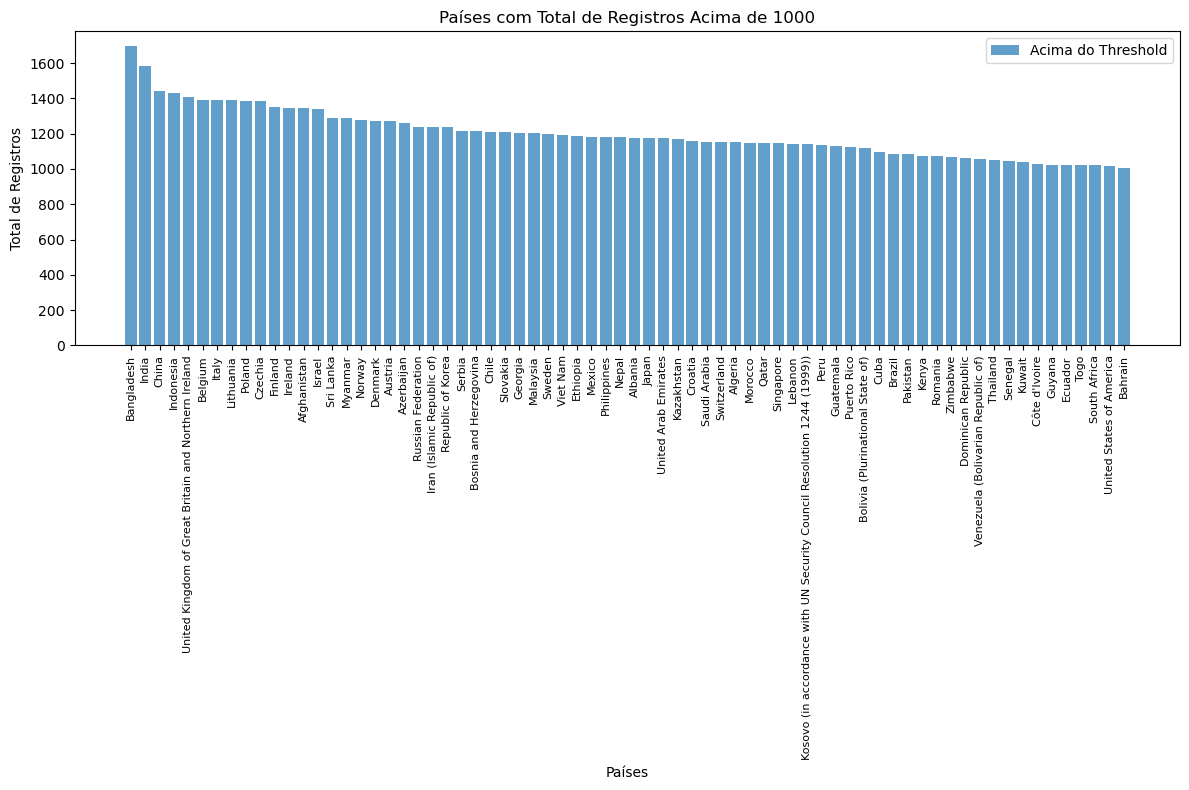

In [17]:
# Exemplo de uso: Exibir apenas países com mais de 1000 registros
plot_countries_by_records(countries_by_records, threshold=1000, filter_above_threshold=True)

In [26]:
country_name = "Finland"
counts = count_null_or_zero(df_deaths, country_name)
counts

New_cases              14
Cumulative_cases        0
New_deaths              0
Cumulative_deaths       0
Total_records        1121
dtype: int64

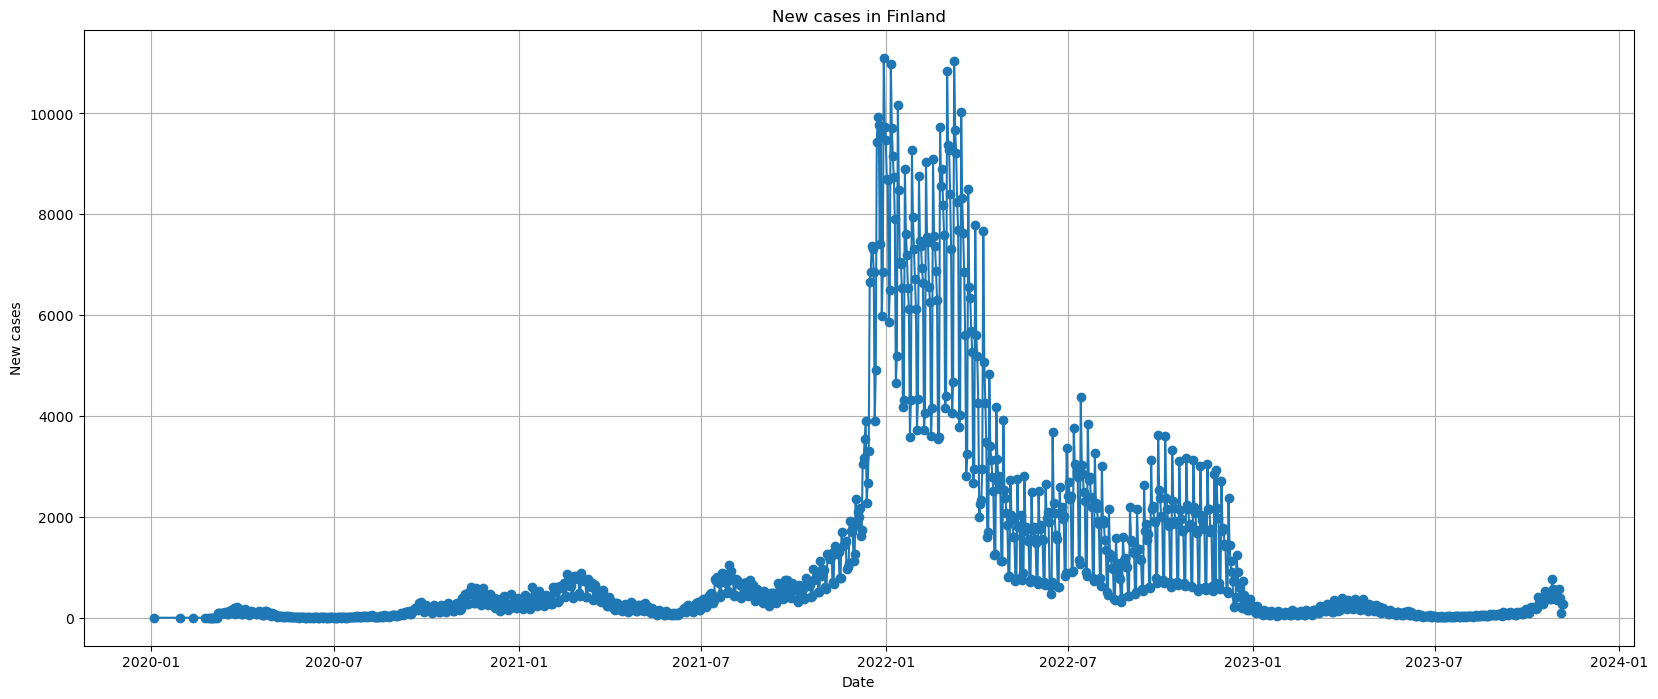

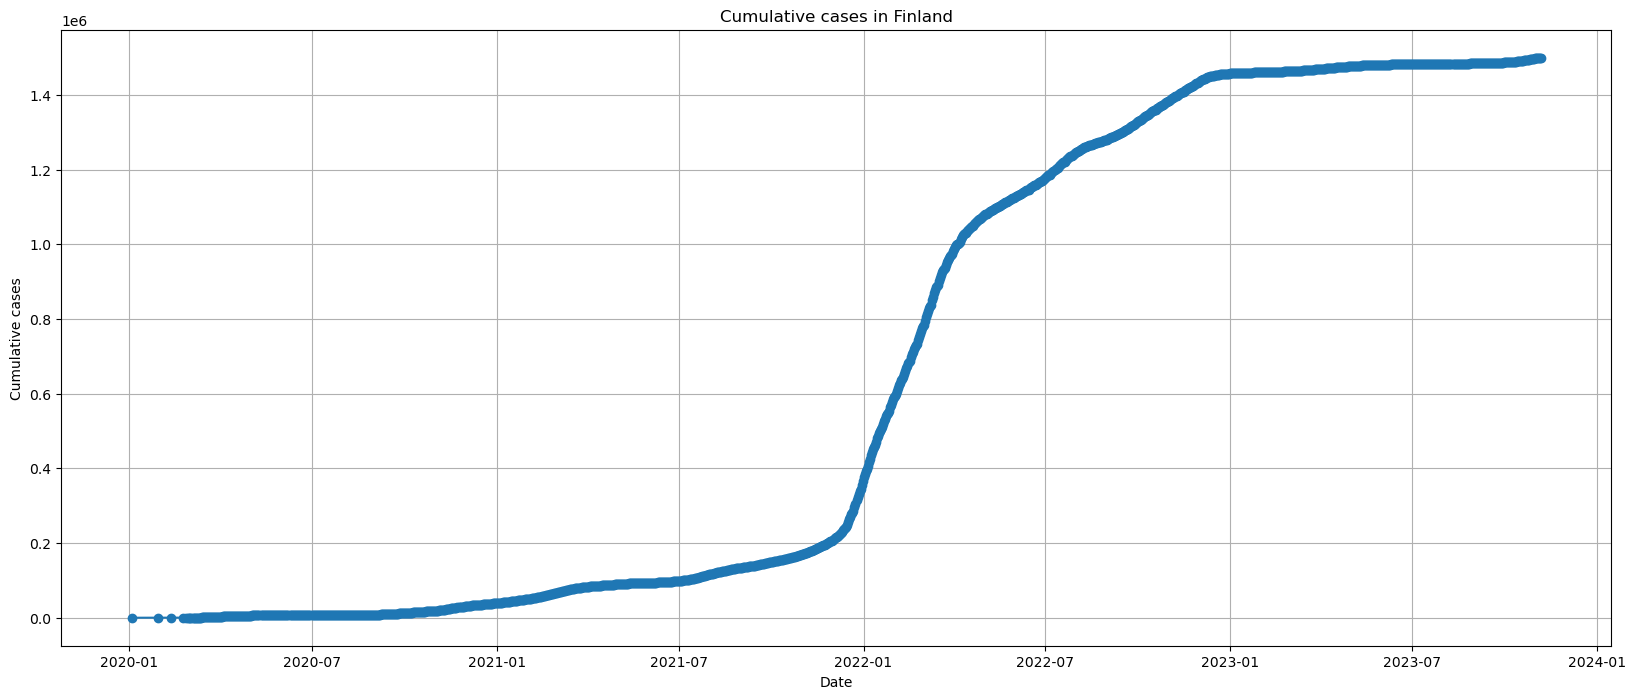

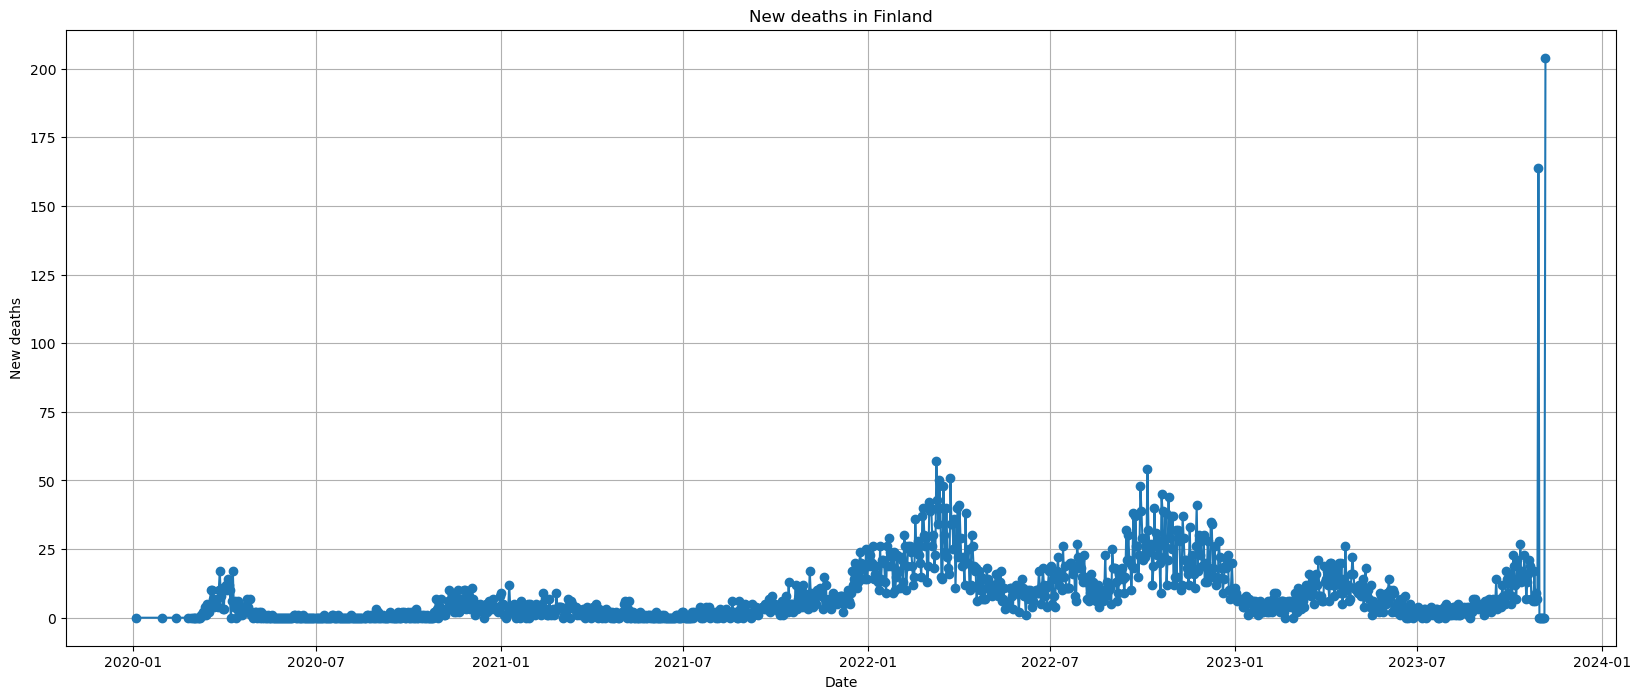

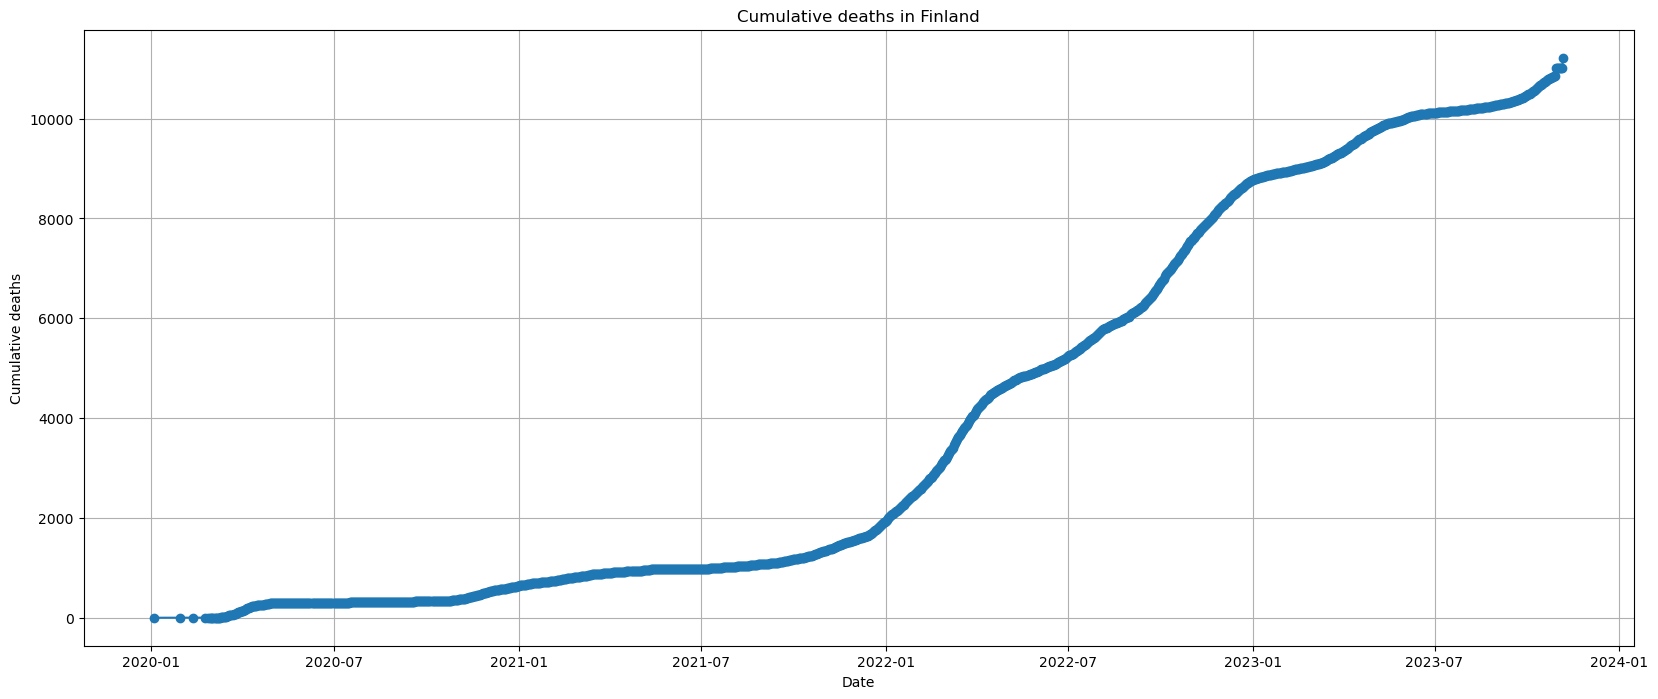

In [27]:
# Exemplo de uso: Plotar os dados por pais
plot_country_data(df_cases, country_name)